In [256]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
import json

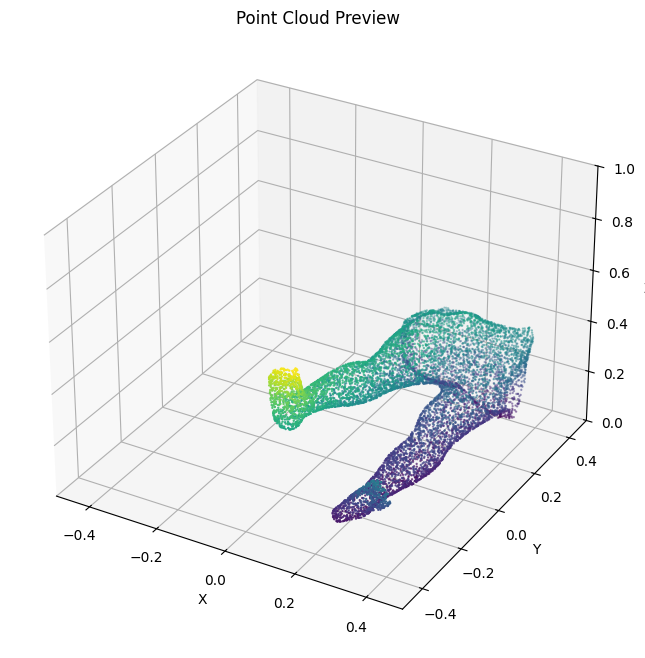

In [263]:
# Load STL mesh
scan_id = "12288"
mesh = o3d.io.read_triangle_mesh("scans_2/" + scan_id + ".stl")
mesh.compute_vertex_normals()

# Sample points on the mesh surface
pcd = mesh.sample_points_uniformly(number_of_points=10000)  # adjust as needed



raw_points = np.asarray(pcd.points)

# Create matplotlib 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(raw_points[:, 0], raw_points[:, 1], raw_points[:, 2],
           c=raw_points[:, 2], cmap='viridis', s=0.5)

ax.set_title('Point Cloud Preview')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)
ax.set_zlim(0, 1)

plt.show()

In [264]:
def load_annotations(annotation_file):
    with open(annotation_file, "r") as f:
        annotations = json.load(f)
    
    model_id_to_keypoints = {}
    for entry in annotations:
        model_id = entry["model_id"]
        keypoints = entry["keypoints"]
        model_id_to_keypoints[model_id] = [kp["xyz"] for kp in keypoints]
    
    return model_id_to_keypoints


def get_keypoints_for_model(model_id, annotation_file):
    model_id_to_keypoints = load_annotations(annotation_file)
    
    if model_id in model_id_to_keypoints:
        return model_id_to_keypoints[model_id]
    else:
        print(f"Model ID {model_id} not found in annotations.")
        return None

In [265]:
annotation_file = "knee_annotations/knees_4_5_aug_flipped.json"  # Path to your annotation file
keypoints = get_keypoints_for_model(scan_id, annotation_file)
if keypoints:
    #for i, kp in enumerate(keypoints):
    #    print(f"{kp[0]:.3f} {kp[1]:.3f} {kp[2]:.3f}")
    thigh_point = np.array(keypoints[0])
    shin_point = np.array(keypoints[1])

#print(thigh_point)

# Example: your model predicts these two points (numpy arrays)
#thigh_point = np.array([-0.055, -0.140, 0.478])
#shin_point  = np.array([-0.071, 0.218, 0.495])

#-0.055 -0.140 0.478
#-0.071 0.218 0.495

# Compute leg axis vector
axis_vec = shin_point - thigh_point
axis_unit = axis_vec / np.linalg.norm(axis_vec)

# Transform all points into axis coordinates
points = np.asarray(pcd.points)

vec_to_points = points - thigh_point  # vectors from thigh point to all points

# Project vectors onto axis to get "height" along the axis
heights = vec_to_points @ axis_unit  # dot product

# Compute radial distance from axis line
proj_points = np.outer(heights, axis_unit)  # projection vectors
radial_vecs = vec_to_points - proj_points
radii = np.linalg.norm(radial_vecs, axis=1)

# Define crop region
height_min = -20  # mm or units below thigh point
height_max = np.linalg.norm(axis_vec) + 20  # mm above shin point
radius_max = 60  # adjust as needed <<<<


height_min = -100
height_max = np.linalg.norm(axis_vec) + 100 
radius_max = 10


print(f"Max height: {np.max(heights):.2f}")
print(f"Max radius: {np.max(radii):.2f}")

# Example dynamic crop
height_min = np.min(heights) + 0.1
height_max = np.max(heights) - 0.1
radius_max = np.max(radii) - 0.2



# Create a mask for points inside cylinder
mask = (
    (heights >= height_min) &
    (heights <= height_max) &
    (radii <= radius_max)
)

# Crop the point cloud
cropped_points = points[mask]
cropped_pcd = o3d.geometry.PointCloud()
cropped_pcd.points = o3d.utility.Vector3dVector(cropped_points)

print(f"axis_unit: {axis_unit}")
print(f"heights: min={np.min(heights):.2f}, max={np.max(heights):.2f}")
print(f"radii: min={np.min(radii):.2f}, max={np.max(radii):.2f}")
print(f"height range: [{height_min}, {height_max}], radius_max: {radius_max}")
print(f"Points before mask: {len(points)}, after mask: {np.sum(mask)}")


'''
# Create matplotlib 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(points[:, 0], points[:, 1], points[:, 2],
           c=points[:, 2], cmap='viridis', s=0.5)

ax.set_title('Point Cloud Preview')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)
ax.set_zlim(0, 1)

plt.show()
'''



points_cropped = np.asarray(cropped_pcd.points)
'''
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(points_cropped[:, 0], points_cropped[:, 1], points_cropped[:, 2],
           c=points_cropped[:, 2], cmap='plasma', s=0.5)

ax.set_title('Power Filtered Point Cloud')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)
ax.set_zlim(0, 1)


plt.show()
'''

#print(f"Before crop: {len(points)} points")
#print(f"After crop: {len(cropped_points)} points")

Max height: 0.68
Max radius: 0.42
axis_unit: [ 0.18650588  0.97720285 -0.10144037]
heights: min=-0.23, max=0.68
radii: min=0.00, max=0.42
height range: [-0.13012050148125187, 0.5771082030699797], radius_max: 0.2229121495953087
Points before mask: 10000, after mask: 4070


"\nfig = plt.figure(figsize=(10, 8))\nax = fig.add_subplot(111, projection='3d')\n\nax.scatter(points_cropped[:, 0], points_cropped[:, 1], points_cropped[:, 2],\n           c=points_cropped[:, 2], cmap='plasma', s=0.5)\n\nax.set_title('Power Filtered Point Cloud')\nax.set_xlabel('X')\nax.set_ylabel('Y')\nax.set_zlabel('Z')\n\nax.set_xlim(-0.5, 0.5)\nax.set_ylim(-0.5, 0.5)\nax.set_zlim(0, 1)\n\n\nplt.show()\n"

In [266]:
# Optionally apply radius outlier removal to remove isolated noise
# (You can also use DBSCAN or connected components)
cl, ind = cropped_pcd.remove_radius_outlier(nb_points=16, radius=0.025)
cleaned_pcd = cropped_pcd.select_by_index(ind)

print(f"After outlier removal: {len(cleaned_pcd.points)} points")

After outlier removal: 3825 points


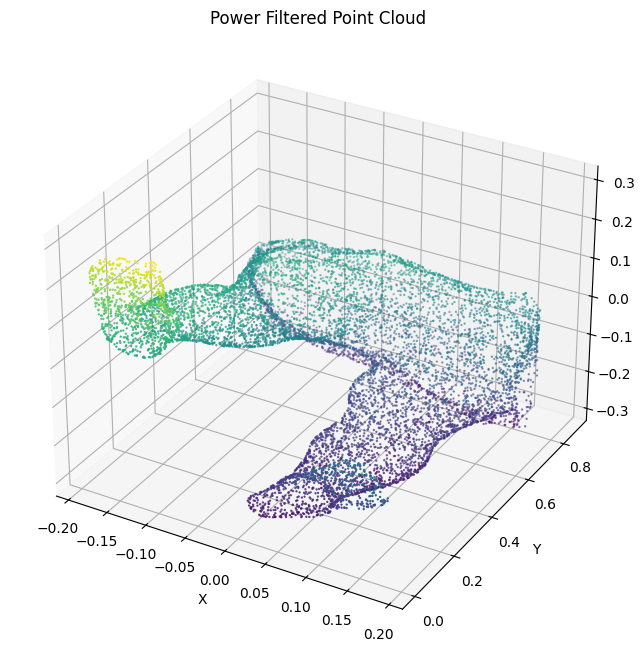

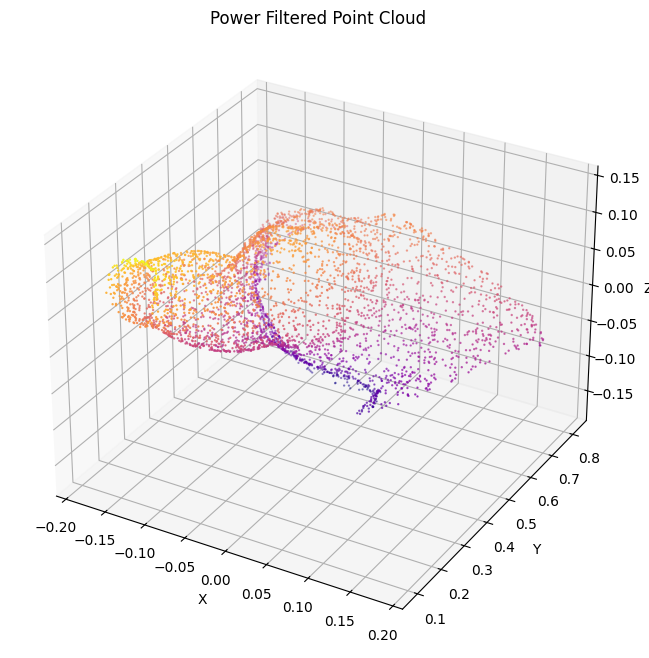

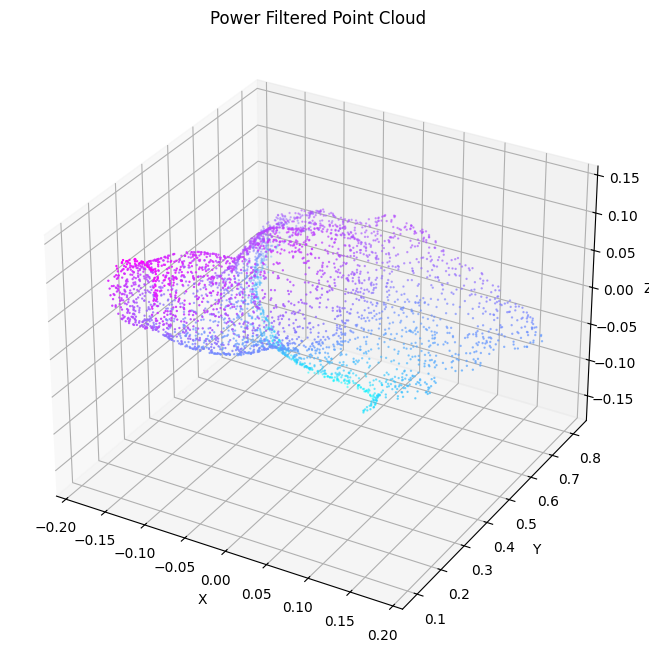

In [267]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(raw_points[:, 0], raw_points[:, 1], raw_points[:, 2],
           c=raw_points[:, 2], cmap='viridis', s=0.5)

ax.set_title('Power Filtered Point Cloud')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

#ax.set_xlim(-0.5, 0.5)
#ax.set_ylim(-0.5, 0.5)
#ax.set_zlim(0, 1)


plt.show()


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(points_cropped[:, 0], points_cropped[:, 1], points_cropped[:, 2],
           c=points_cropped[:, 2], cmap='plasma', s=0.5)

ax.set_title('Power Filtered Point Cloud')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

#ax.set_xlim(-0.5, 0.5)
#ax.set_ylim(-0.5, 0.5)
#ax.set_zlim(0, 1)

plt.show()


cleaned_points = np.asarray(cleaned_pcd.points)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(cleaned_points[:, 0], cleaned_points[:, 1], cleaned_points[:, 2],
           c=cleaned_points[:, 2], cmap='cool', s=0.5)

ax.set_title('Power Filtered Point Cloud')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

#ax.set_xlim(-0.5, 0.5)
#ax.set_ylim(-0.5, 0.5)
#ax.set_zlim(0, 1)

plt.show()


In [268]:
# Save to a PLY file
o3d.io.write_point_cloud("filtered_point_cloud.ply", cleaned_pcd)

True